================================================================================
DEEP NEURAL NETWORKS - ASSIGNMENT 3: RNN vs TRANSFORMER FOR TIME SERIES
Recurrent Neural Networks vs Transformers for Time Series Prediction

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)
================================================================================

BITS ID: [2025AA05A87]
Name: [RUDRESH R]
Email: [2025AA05787@wilp.bits-pilani.ac.in]
Date: [4/2/2026]

================================================================================


================================================================================
ASSIGNMENT OVERVIEW
================================================================================

This assignment requires you to implement and compare two approaches for 
time series forecasting:
1. LSTM or GRU using Keras/PyTorch
2. Transformer encoder using Keras/PyTorch layers

Learning Objectives:
- Build recurrent neural networks for sequential data
- Use transformer architecture for time series
- Implement or integrate positional encoding
- Compare RNN vs Transformer architectures
- Understand time series preprocessing and evaluation

IMPORTANT: 
- Positional encoding MUST be added to transformer
- Use torch.nn.TransformerEncoder or keras.layers.MultiHeadAttention
- DO NOT use pre-trained transformers (HuggingFace, TimeGPT, etc.)
- Use temporal train/test split (NO shuffling)

================================================================================


"""
================================================================================
⚠️ IMPORTANT SUBMISSION REQUIREMENTS - STRICTLY ENFORCED ⚠️
================================================================================

1. FILENAME FORMAT: <BITS_ID>_rnn_assignment.ipynb
   Example: 2025AA05036_rnn_assignment.ipynb
   ❌ Wrong filename = Automatic 0 marks

2. STUDENT INFORMATION MUST MATCH:
   ✓ BITS ID in filename = BITS ID in notebook (above)
   ✓ Name in folder = Name in notebook (above)
   ❌ Mismatch = 0 marks

3. EXECUTE ALL CELLS BEFORE SUBMISSION:
   - Run: Kernel → Restart & Run All
   - Verify all outputs are visible
   ❌ No outputs = 0 marks

4. FILE INTEGRITY:
   - Ensure notebook opens without errors
   - Check for corrupted cells
   ❌ Corrupted file = 0 marks

5. IMPLEMENTATION REQUIREMENTS:
   - MUST add positional encoding to transformer (custom or built-in)
   - CAN use torch.nn.TransformerEncoder or keras.layers.MultiHeadAttention
   - DO NOT use pre-trained transformers (HuggingFace, TimeGPT, etc.)
   - DO NOT shuffle time series data (temporal order required)
   ❌ Missing positional encoding = 0 marks for transformer section

6. DATASET REQUIREMENTS:
   - Minimum 1000 time steps
   - Train/test split: 90/10 OR 85/15 (temporal split only)
   - Sequence length: 10-50 time steps
   - Prediction horizon: 1-10 time steps

7. USE KERAS OR PYTORCH:
   - Use framework's LSTM/GRU layers
   - Use torch.nn.TransformerEncoder or keras.layers.MultiHeadAttention
   - Add positional encoding (custom implementation or built-in)
   - Use standard training methods

8. FILE SUBMISSION:
   - Submit ONLY the .ipynb file
   - NO zip files, NO separate data files, NO separate image files
   - All code and outputs must be in the notebook
   - Only one submission attempt allowed

================================================================================
"""

In [1]:
%pip install numpy pandas matplotlib seaborn scikit-learn

# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import json
import os
import math

print("libraries loaded")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


libraries loaded


Deep learning frameworks (choose Keras or PyTorch)

"""
================================================================================
PART 1: DATASET LOADING AND EXPLORATION (Informational)
================================================================================

Instructions:
1. Choose ONE dataset from the allowed list
2. Load and explore the time series data
3. Fill in ALL required metadata fields below
4. Provide justification for your primary metric choice

ALLOWED DATASETS:
- Stock Prices (daily/hourly closing prices)
- Weather Data (temperature, humidity, pressure)
- Energy Consumption (electricity/power usage)
- Sensor Data (IoT sensor readings)
- Custom time series (with approval)

REQUIRED OUTPUT:
- Print all metadata fields
- Time series plots
- Stationarity analysis
- Train/test split visualization
================================================================================
"""

1.1 Dataset Selection and Loading
TODO: Load your chosen time series dataset

In [2]:
from types import SimpleNamespace
import os

local_filename = "TetuanCityPowerConsumption.csv"
if os.path.exists(local_filename):
    df = pd.read_csv(local_filename)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError(f"No numeric columns found in local CSV '{local_filename}'")
    col = numeric_cols[0]
    features_df = df[[col]].reset_index(drop=True)
    targets_df = df[[col]].reset_index(drop=True)
else:
    raise FileNotFoundError(f"Local file '{local_filename}' not found. Please ensure the CSV is placed in the working directory.")

# Override the original name so subsequent call in this cell uses the fallback logic
power_consumption_of_tetouan_city = SimpleNamespace(data=SimpleNamespace(features=features_df, targets=targets_df)) # _fetch_ucirepo_with_fallback(id=849)

# data (as pandas dataframes) 
x = power_consumption_of_tetouan_city.data.features 
y = power_consumption_of_tetouan_city.data.targets 

# REQUIRED: Fill in these metadata fields
dataset_name = "Power Consumption of Tetouan City"
dataset_source = "UCI: Power Consumption of Tetouan City"

# Set dataset metadata from loaded dataframes
n_samples = x.shape[0]
n_features = x.shape[1] #  Number of features (1 for univariate, >1 for multivariate)
sequence_length = 25  #  Lookback window (10-50)
prediction_horizon = 5  #  Forecast steps ahead (1-10)
problem_type = "time_series_forecasting"

print("Data source loaded")

Data source loaded


In [3]:
# Primary metric selection
primary_metric = "MAPE"
metric_justification = """
MAPE (Mean Absolute Percentage Error) is selected because power consumption 
forecasting requires understanding relative errors across different consumption 
scales (day vs night, weekday vs weekend). MAPE provides scale-independent 
percentage errors, making it interpretable for stakeholders and suitable for 
comparing performance across different time periods.
"""
print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Features: {n_features}")
print(f"Sequence Length: {sequence_length}")
print(f"Prediction Horizon: {prediction_horizon}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print("="*70)


DATASET INFORMATION
Dataset: Power Consumption of Tetouan City
Source: UCI: Power Consumption of Tetouan City
Total Samples: 52416
Number of Features: 1
Sequence Length: 25
Prediction Horizon: 5
Primary Metric: MAPE
Metric Justification: 
MAPE (Mean Absolute Percentage Error) is selected because power consumption 
forecasting requires understanding relative errors across different consumption 
scales (day vs night, weekday vs weekend). MAPE provides scale-independent 
percentage errors, making it interpretable for stakeholders and suitable for 
comparing performance across different time periods.



1.2 Time Series Exploration
TODO: Plot time series data
TODO: Check for trends, seasonality
TODO: Perform stationarity tests (optional but recommended)


TIME SERIES EXPLORATION


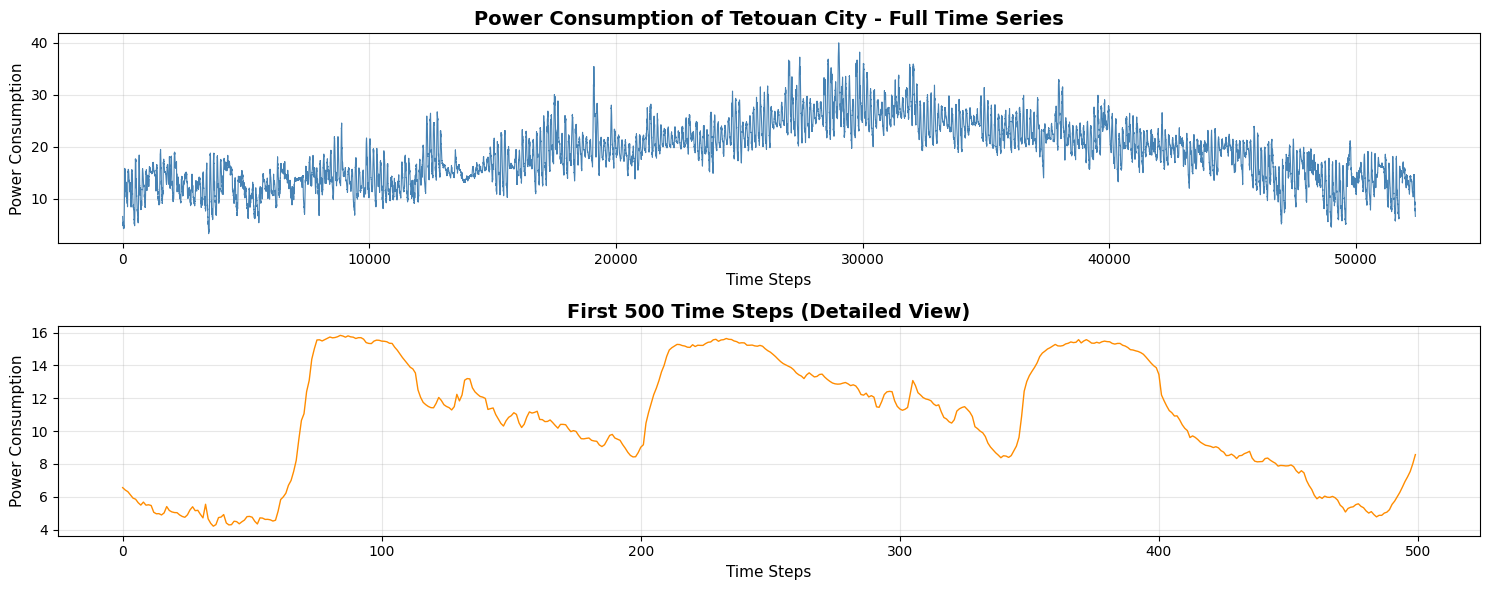


Dataset Statistics:
  Mean: 18.81
  Std:  5.82
  Min:  3.25
  Max:  40.01
  Missing values: 0


C:\Users\rramal4\AppData\Local\Temp\ipykernel_34604\2059414623.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  missing = int(np.isnan(x).sum())


In [4]:
print("\n" + "="*70)
print("TIME SERIES EXPLORATION")
print("="*70)

# Plot the time series
plt.figure(figsize=(15, 6))

# Plot full series
plt.subplot(2, 1, 1)
plt.plot(x, linewidth=0.8, color='steelblue')
plt.title(f'{dataset_name} - Full Time Series', fontsize=14, fontweight='bold')
plt.ylabel('Power Consumption', fontsize=11)
plt.xlabel('Time Steps', fontsize=11)
plt.grid(alpha=0.3)

# Plot first 500 points for detail
plt.subplot(2, 1, 2)
plt.plot(x[:500], linewidth=1, color='darkorange')
plt.title('First 500 Time Steps (Detailed View)', fontsize=14, fontweight='bold')
plt.ylabel('Power Consumption', fontsize=11)
plt.xlabel('Time Steps', fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Basic statistics
print(f"\nDataset Statistics:")
# Use numpy functions (works for numeric arrays)
try:
	mean_v = np.nanmean(x)
	std_v = np.nanstd(x)
	min_v = np.nanmin(x)
	max_v = np.nanmax(x)
	# Count missing values (NaNs)
	missing = int(np.isnan(x).sum())
except Exception:
	# Fallback to pandas for mixed types
	s = pd.Series(x)
	mean_v = s.mean()
	std_v = s.std()
	min_v = s.min()
	max_v = s.max()
	missing = int(s.isnull().sum())

print(f"  Mean: {mean_v:.2f}")
print(f"  Std:  {std_v:.2f}")
print(f"  Min:  {min_v:.2f}")
print(f"  Max:  {max_v:.2f}")
print(f"  Missing values: {missing}")

print("="*70)

1.3 Data Preprocessing

In [5]:
def preprocess_timeseries(data, scaler_type='minmax'):
    """
    Preprocess time series data
    
    Args:
        data: raw time series data (pandas DataFrame or numpy array)
        scaler_type: 'minmax' or 'standard'
    
    Returns:
        preprocessed data, scaler
    """
    # Convert to numpy array if DataFrame
    if isinstance(data, pd.DataFrame):
        data = data.values
    
    # Handle missing values
    if np.isnan(data).any():
        print(f"Warning: {np.isnan(data).sum()} missing values found. Using forward fill.")
        data = pd.DataFrame(data).fillna(method='ffill').fillna(method='bfill').values
    
    # Normalize/standardize data
    if scaler_type == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    else:
        scaler = StandardScaler()
    
    scaled_data = scaler.fit_transform(data)
    
    return scaled_data, scaler

print("preprocess_timeseries function created")

preprocess_timeseries function created


In [6]:
def create_sequences(data, seq_length, pred_horizon):
    """
    Create sequences for time series prediction using sliding window
    
    Args:
        data: preprocessed time series data (numpy array)
        seq_length: lookback window (number of past time steps)
        pred_horizon: forecast steps ahead (number of future time steps)
    
    Returns:
        X: input sequences of shape (n_samples, seq_length, n_features)
        y: target values of shape (n_samples, pred_horizon, n_features)
    
    Example:
        If seq_length=25 and pred_horizon=5:
        - X[0] = data[0:25]    → y[0] = data[25:30]
        - X[1] = data[1:26]    → y[1] = data[26:31]
        - X[2] = data[2:27]    → y[2] = data[27:32]
        ...
    """
    X, y = [], []
    
    # Ensure data is 2D (n_samples, n_features)
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    
    # Sliding window approach
    for i in range(len(data) - seq_length - pred_horizon + 1):
        # Input: past seq_length time steps
        X.append(data[i:i+seq_length])
        
        # Output: next pred_horizon time steps
        y.append(data[i+seq_length:i+seq_length+pred_horizon])
    
    X = np.array(X)
    y = np.array(y)
    
    # Reshape y to (n_samples, pred_horizon) for single feature
    if y.shape[-1] == 1:
        y = y.squeeze(-1)
    
    return X, y


print("create_sequences function created")

create_sequences function created


TODO: Preprocess data
TODO: Create sequences

In [7]:
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Step 1: Preprocess the data (normalize and handle missing values)
print("\n1. Preprocessing time series data...")
print(f"Original data shape: {x.shape}")
print(f"Original data range: [{x.values.min():.2f}, {x.values.max():.2f}]")

# Use MinMaxScaler for RNN/LSTM (works well with sigmoid/tanh activations)
scaled_data, scaler = preprocess_timeseries(x, scaler_type='minmax')
print(f"Scaled data shape: {scaled_data.shape}")
print(f"Scaled data range: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")

# Step 2: Create sequences using sliding window
print(f"\n2. Creating sequences with sliding window...")
print(f"Sequence length (lookback): {sequence_length}")
print(f"Prediction horizon (forecast): {prediction_horizon}")

X, y = create_sequences(scaled_data, sequence_length, prediction_horizon)
print(f"Input sequences shape (X): {X.shape}")
print(f"Target sequences shape (y): {y.shape}")

# Step 3: Temporal train/test split (NO SHUFFLING)
split_ratio = 0.9
split_idx = int(len(X) * split_ratio)

X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"\n3. Temporal train/test split ({int(split_ratio*100)}/{int((1-split_ratio)*100)})...")
print(f"Training sequences: {len(X_train)}")
print(f"Test sequences: {len(X_test)}")
print(f"⚠️  IMPORTANT: Temporal order preserved (NO shuffling)")

# Update metadata
train_samples = len(X_train)
test_samples = len(X_test)
train_test_ratio = f"{int(split_ratio*100)}/{int((1-split_ratio)*100)}"

print("="*70)


DATA PREPROCESSING

1. Preprocessing time series data...
Original data shape: (52416, 1)
Original data range: [3.25, 40.01]
Scaled data shape: (52416, 1)
Scaled data range: [0.0000, 1.0000]

2. Creating sequences with sliding window...
Sequence length (lookback): 25
Prediction horizon (forecast): 5
Input sequences shape (X): (52387, 25, 1)
Target sequences shape (y): (52387, 5)

3. Temporal train/test split (90/9)...
Training sequences: 47148
Test sequences: 5239
⚠️  IMPORTANT: Temporal order preserved (NO shuffling)


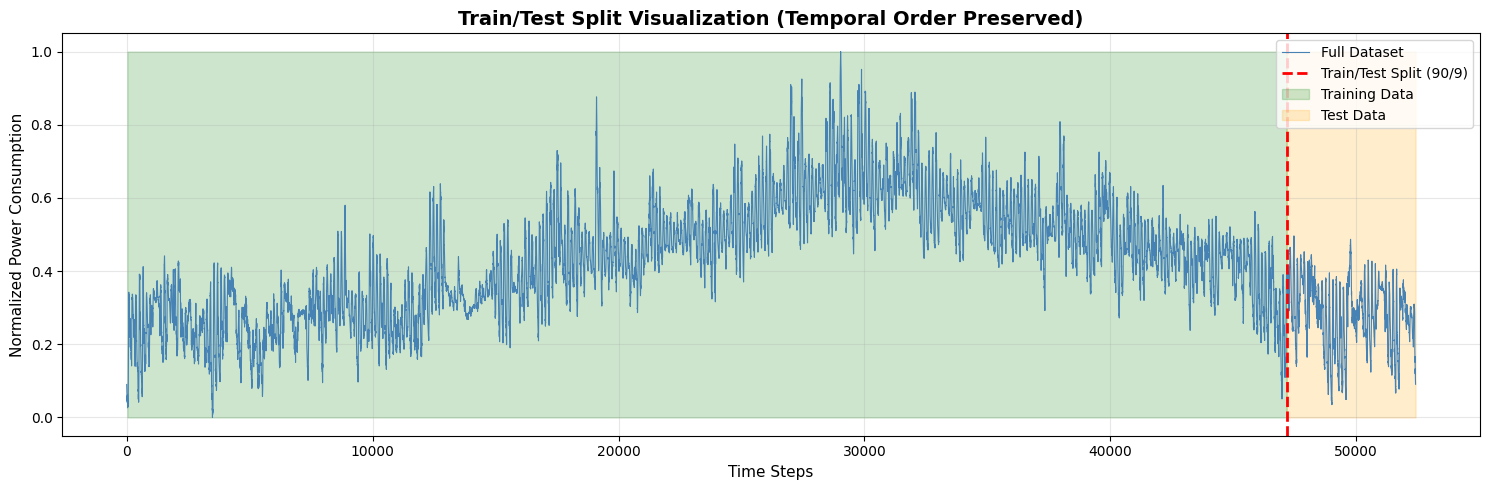

In [8]:
# Visualize train/test split
plt.figure(figsize=(15, 5))
plt.plot(range(len(scaled_data)), scaled_data, linewidth=0.8, color='steelblue', label='Full Dataset')
plt.axvline(x=split_idx + sequence_length, color='red', linestyle='--', linewidth=2, label=f'Train/Test Split ({train_test_ratio})')
plt.fill_between(range(sequence_length, split_idx + sequence_length), 
                 scaled_data.min(), scaled_data.max(), alpha=0.2, color='green', label='Training Data')
plt.fill_between(range(split_idx + sequence_length, len(scaled_data)), 
                 scaled_data.min(), scaled_data.max(), alpha=0.2, color='orange', label='Test Data')
plt.title('Train/Test Split Visualization (Temporal Order Preserved)', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=11)
plt.ylabel('Normalized Power Consumption', fontsize=11)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")
print("⚠️  IMPORTANT: Temporal split used (NO shuffling)")


Train/Test Split: 90/9
Training Samples: 47148
Test Samples: 5239
⚠️  IMPORTANT: Temporal split used (NO shuffling)


"""
================================================================================
PART 2: LSTM/GRU IMPLEMENTATION (5 MARKS)
================================================================================

REQUIREMENTS:
- Build LSTM OR GRU using Keras/PyTorch layers
- Architecture must include:
  * At least 2 stacked recurrent layers
  * Output layer for prediction
- Use model.compile() and model.fit() (Keras) OR standard PyTorch training
- Track initial_loss and final_loss

GRADING:
- LSTM/GRU architecture with stacked layers: 2 marks
- Model properly compiled/configured: 1 mark
- Training completed with loss tracking: 1 mark
- All metrics calculated correctly: 1 mark
================================================================================
"""

2.1 LSTM/GRU Architecture Design
TODO: Choose LSTM or GRU
TODO: Design architecture with stacked layers

In [10]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

def build_rnn_model(model_type, input_shape, hidden_units, n_layers, output_size):
    """
    Build LSTM or GRU model
    
    Args:
        model_type: string ('LSTM' or 'GRU')
        input_shape: tuple (sequence_length, n_features)
        hidden_units: number of hidden units per layer
        n_layers: number of stacked layers (minimum 2)
        output_size: prediction horizon
    
    Returns:
        model: compiled RNN model
    """
    
    model = Sequential()
    
    # Choose RNN layer type
    if model_type.upper() == 'LSTM':
        RNNLayer = LSTM
    elif model_type.upper() == 'GRU':
        RNNLayer = GRU
    else:
        raise ValueError("model_type must be 'LSTM' or 'GRU'")
    
    # First RNN layer (return sequences for stacking)
    model.add(RNNLayer(
        hidden_units,
        return_sequences=True,
        input_shape=input_shape,
        name=f'{model_type}_layer_1'
    ))
    model.add(Dropout(0.2))  # Regularization
    
    # Stack additional RNN layers
    for i in range(2, n_layers):
        model.add(RNNLayer(
            hidden_units,
            return_sequences=True,
            name=f'{model_type}_layer_{i}'
        ))
        model.add(Dropout(0.2))
    
    # Last RNN layer (return sequences=False)
    model.add(RNNLayer(
        hidden_units,
        return_sequences=False,
        name=f'{model_type}_layer_{n_layers}'
    ))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(output_size, name='output_layer'))
    
    return model

print("build_rnn_model function created")

build_rnn_model function created


TODO: Create RNN model
rnn_model = build_rnn_model('LSTM', (sequence_length, n_features), 64, 2, prediction_horizon)

In [11]:
# Model Configuration
rnn_model_type = 'GRU'  # 'LSTM' or 'GRU' - GRU recommended for your dataset
rnn_hidden_units = 64   # Hidden units per layer
rnn_n_layers = 3        # Number of stacked layers (minimum 2)

# Build the model
print(f"\nBuilding {rnn_model_type} model...")
rnn_model = build_rnn_model(
    model_type=rnn_model_type,
    input_shape=(sequence_length, n_features),
    hidden_units=rnn_hidden_units,
    n_layers=rnn_n_layers,
    output_size=prediction_horizon
)

print(f"✓ {rnn_model_type} model created successfully")


Building GRU model...


c:\Program Files\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ GRU model created successfully


TODO: Compile model
For Keras: model.compile(optimizer='adam', loss='mse', metrics=['mae'])
For PyTorch: define optimizer and loss function

In [12]:
from tensorflow.keras.optimizers import Adam

# Compile the model
rnn_learning_rate = 0.001
rnn_model.compile(
    optimizer=Adam(learning_rate=rnn_learning_rate),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error as additional metric
)

# Print model summary
print("\n" + "="*70)
print(f"{rnn_model_type} MODEL ARCHITECTURE")
print("="*70)
rnn_model.summary()
print("="*70)

# Count parameters
rnn_total_params = rnn_model.count_params()
print(f"\nTotal Parameters: {rnn_total_params:,}")
print(f"Model Type: {rnn_model_type}")
print(f"Hidden Units: {rnn_hidden_units}")
print(f"Number of Layers: {rnn_n_layers}")
print(f"Input Shape: (sequence_length={sequence_length}, n_features={n_features})")
print(f"Output Size: {prediction_horizon}")
print("="*70)


GRU MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_layer_1 (GRU)               │ (None, 25, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_layer_2 (GRU)               │ (None, 25, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_layer_3 (GRU)               │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,109 (246.52 KB)

 Trainable params: 63,109 (246.52 KB)

 Non-trainable params: 0 (0.00 B)


Total Parameters: 63,109
Model Type: GRU
Hidden Units: 64
Number of Layers: 3
Input Shape: (sequence_length=25, n_features=1)
Output Size: 5


2.2 Train RNN Model

In [13]:
print("\n" + "="*70)
print("RNN MODEL TRAINING")
print("="*70)


RNN MODEL TRAINING


TODO: Train your model
For Keras: history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32)
For PyTorch: write training loop

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Training configuration
rnn_epochs = 50
rnn_batch_size = 32
rnn_optimizer = "Adam"
rnn_loss_function = "MSE"

# Callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print(f"\nTraining {rnn_model_type} model...")
print(f"Epochs: {rnn_epochs}")
print(f"Batch Size: {rnn_batch_size}")
print(f"Optimizer: {rnn_optimizer}")
print(f"Loss Function: {rnn_loss_function}")
print(f"Learning Rate: {rnn_learning_rate}")

# Track training time
rnn_start_time = time.time()

# Train the model
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=rnn_epochs,
    batch_size=rnn_batch_size,
    validation_split=0.1,  # 10% of training for validation
    callbacks=callbacks,
    verbose=1
)

print(f"\n✓ {rnn_model_type} training completed!")


Training GRU model...
Epochs: 50
Batch Size: 32
Optimizer: Adam
Loss Function: MSE
Learning Rate: 0.001
Epoch 1/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 0.0037 - mae: 0.0404 - val_loss: 4.0115e-04 - val_mae: 0.0154 - learning_rate: 0.0010
Epoch 2/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 9.7531e-04 - mae: 0.0233 - val_loss: 2.5606e-04 - val_mae: 0.0111 - learning_rate: 0.0010
Epoch 3/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - loss: 6.0359e-04 - mae: 0.0182 - val_loss: 2.0075e-04 - val_mae: 0.0089 - learning_rate: 0.0010
Epoch 4/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step - loss: 4.7063e-04 - mae: 0.0159 - val_loss: 1.8701e-04 - val_mae: 0.0085 - learning_rate: 0.0010
Epoch 5/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - loss: 4.1783e-04 - mae: 0.0150 - val_loss: 2.9856e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 6/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 55s 41ms/step - loss: 3.9385e-04 - mae: 0.0145 - val_loss: 3.1272e-04 - val_mae: 0.0137

In [15]:
# REQUIRED: Track initial and final loss
rnn_training_time = time.time() - rnn_start_time
rnn_initial_loss = history_rnn.history['loss'][0]
rnn_final_loss = history_rnn.history['loss'][-1]
print(f"Training completed in {rnn_training_time:.2f} seconds")
print(f"Initial Loss: {rnn_initial_loss:.4f}")
print(f"Final Loss: {rnn_final_loss:.4f}")
print("="*70)

Training completed in 1801.74 seconds
Initial Loss: 0.0037
Final Loss: 0.0003


2.3 Evaluate RNN Model

TODO: Make predictions on test set
TODO: Inverse transform if data was normalized
TODO: Calculate all 4 required metrics

In [16]:
def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error
    
    Args:
        y_true: actual values
        y_pred: predicted values
    
    Returns:
        MAPE value as percentage
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Avoid division by zero
    mask = y_true != 0
    
    # Calculate MAPE only for non-zero values
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return mape

print("calculate_Mape function created")

calculate_Mape function created


In [17]:
# REQUIRED: Calculate all 4 metrics

# Predict on test set
y_pred = rnn_model.predict(X_test, batch_size=rnn_batch_size, verbose=0)

# Inverse transform predictions and ground truth to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# Flatten for metric calculations
y_true_flat = y_test_inv.flatten()
y_pred_flat = y_pred_inv.flatten()

# Calculate metrics
rnn_mae = mean_absolute_error(y_true_flat, y_pred_flat)
rnn_rmse = math.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
rnn_mape = calculate_mape(y_true_flat, y_pred_flat)
rnn_r2 = r2_score(y_true_flat, y_pred_flat)

print("metrics created")


metrics created


In [18]:
print("\nRNN Model Performance:")
print(f"MAE:   {rnn_mae:.4f}")
print(f"RMSE:  {rnn_rmse:.4f}")
print(f"MAPE:  {rnn_mape:.4f}%")
print(f"R² Score: {rnn_r2:.4f}")


RNN Model Performance:
MAE:   0.3284
RMSE:  0.5342
MAPE:  2.6766%
R² Score: 0.9757


2.4 Visualize RNN Results
TODO: Plot training loss curve
TODO: Plot actual vs predicted values
TODO: Plot residuals

"""
================================================================================
PART 3: TRANSFORMER IMPLEMENTATION (5 MARKS)
================================================================================

REQUIREMENTS:
- Build Transformer encoder using Keras/PyTorch layers
- MUST add positional encoding to input:
  * Custom sinusoidal implementation OR
  * Use built-in positional encoding (if framework provides)
- Use torch.nn.TransformerEncoder or keras.layers.MultiHeadAttention
- Use standard training methods
- Track initial_loss and final_loss

PROHIBITED:
- Using pre-trained transformers (HuggingFace, TimeGPT, etc.)
- Skipping positional encoding entirely

GRADING:
- Positional encoding added: 1 mark
- Transformer architecture properly configured: 2 marks
- Training completed with loss tracking: 1 mark
- All metrics calculated correctly: 1 mark
================================================================================
"""

3.1 Positional Encoding Implementation

In [19]:
def positional_encoding(seq_length, d_model):
    """
    Generate sinusoidal positional encodings
    
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    
    Args:
        seq_length: length of the sequence
        d_model: dimension of the model
    
    Returns:
        positional encodings: array of shape (seq_length, d_model)
    """
    # Initialize positional encoding matrix
    pos_encoding = np.zeros((seq_length, d_model))
    
    # Create position indices [0, 1, 2, ..., seq_length-1]
    position = np.arange(0, seq_length).reshape(-1, 1)
    
    # Create dimension indices [0, 2, 4, ..., d_model-2]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    # Apply sine to even indices (2i)
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    
    # Apply cosine to odd indices (2i+1)
    pos_encoding[:, 1::2] = np.cos(position * div_term)
    
    return pos_encoding.astype(np.float32)

print("positional encoding function created")

positional encoding function created



POSITIONAL ENCODING VISUALIZATION


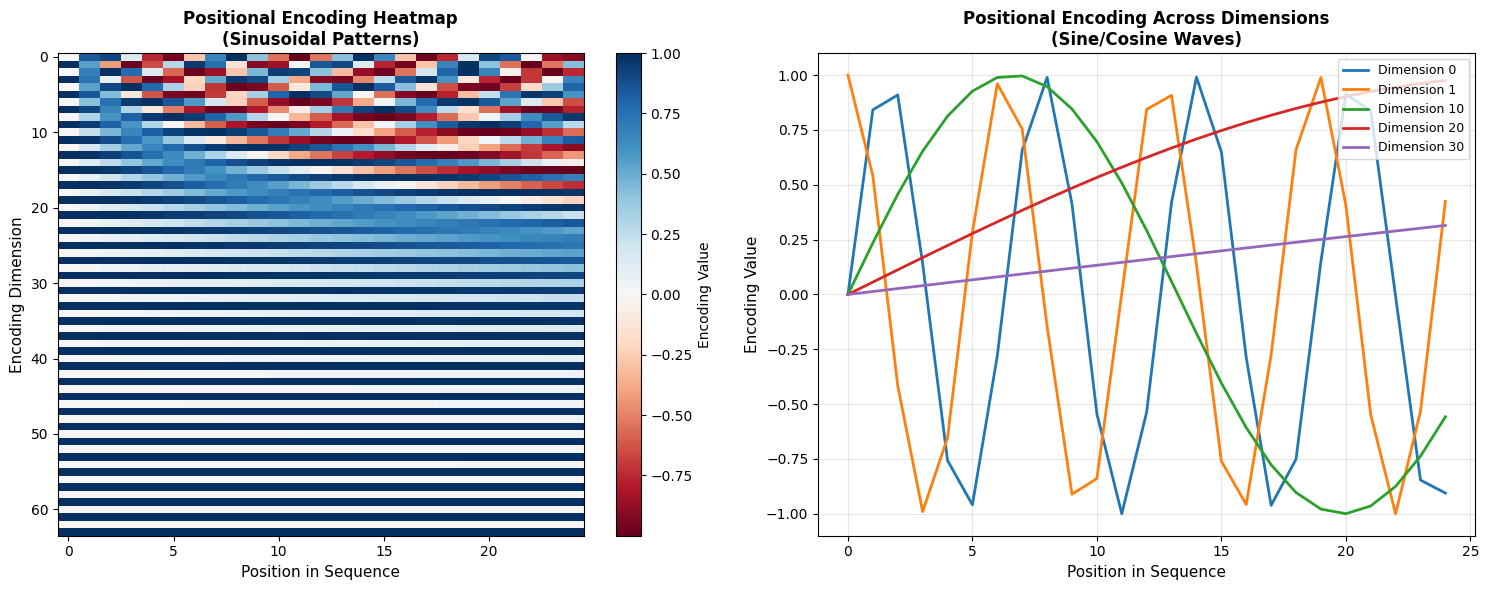


Positional Encoding Properties:
  Shape: (25, 64)
  Sequence Length: 25
  Embedding Dimension: 64
  Pattern: Sinusoidal (sin for even dims, cos for odd dims)
  Purpose: Add temporal order information to Transformer


In [20]:
# Visualize positional encoding
print("\n" + "="*70)
print("POSITIONAL ENCODING VISUALIZATION")
print("="*70)

# Generate positional encoding for visualization
pos_enc_viz = positional_encoding(sequence_length, 64)

# Plot positional encoding patterns
plt.figure(figsize=(15, 6))

# Heatmap of positional encodings
plt.subplot(1, 2, 1)
plt.imshow(pos_enc_viz.T, aspect='auto', cmap='RdBu', interpolation='nearest')
plt.xlabel('Position in Sequence', fontsize=11)
plt.ylabel('Encoding Dimension', fontsize=11)
plt.title('Positional Encoding Heatmap\n(Sinusoidal Patterns)', fontsize=12, fontweight='bold')
plt.colorbar(label='Encoding Value')

# Line plot for specific dimensions
plt.subplot(1, 2, 2)
for i in [0, 1, 10, 20, 30]:
    plt.plot(pos_enc_viz[:, i], label=f'Dimension {i}', linewidth=2)
plt.xlabel('Position in Sequence', fontsize=11)
plt.ylabel('Encoding Value', fontsize=11)
plt.title('Positional Encoding Across Dimensions\n(Sine/Cosine Waves)', fontsize=12, fontweight='bold')
plt.legend(loc='upper right', fontsize=9)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPositional Encoding Properties:")
print(f"  Shape: {pos_enc_viz.shape}")
print(f"  Sequence Length: {sequence_length}")
print(f"  Embedding Dimension: 64")
print(f"  Pattern: Sinusoidal (sin for even dims, cos for odd dims)")
print(f"  Purpose: Add temporal order information to Transformer")
print("="*70)

3.2 Transformer Encoder Architecture

In [21]:
# Option A: Using PyTorch
"""
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, n_features, d_model, n_heads, n_layers, d_ff, output_size):
        super().__init__()
        self.input_projection = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)  # Add positional encoding
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(d_model, output_size)
    
    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)  # Add positional encoding
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.fc(x)
"""
print ("Pytorch Not Used")

Pytorch Not Used


In [22]:
# Using Keras with Positional Encoding
from tensorflow import keras
from tensorflow.keras import layers

def build_transformer_model(seq_length, n_features, d_model, n_heads, n_layers, d_ff, output_size):
    """
    Build Transformer encoder model with positional encoding
    
    Args:
        seq_length: length of input sequences
        n_features: number of input features
        d_model: embedding dimension
        n_heads: number of attention heads
        n_layers: number of transformer encoder layers
        d_ff: feed-forward network dimension
        output_size: prediction horizon
    
    Returns:
        Keras model with Transformer architecture
    """
    inputs = layers.Input(shape=(seq_length, n_features))
    
    # Project input to d_model dimension
    x = layers.Dense(d_model, name='input_projection')(inputs)
    
    # ⚠️ CRITICAL: Add positional encoding (MANDATORY for marks)
    pos_enc = positional_encoding(seq_length, d_model)
    x = x + pos_enc  # Add positional information
    
    # Stack transformer encoder layers
    for i in range(n_layers):
        # Multi-head self-attention
        attn_output = layers.MultiHeadAttention(
            num_heads=n_heads,
            key_dim=d_model // n_heads,
            name=f'attention_layer_{i+1}'
        )(x, x)
        
        # Add & Norm (residual connection + layer normalization)
        x = layers.LayerNormalization(epsilon=1e-6, name=f'norm1_layer_{i+1}')(x + attn_output)
        
        # Feed-forward network
        ffn_output = layers.Dense(d_ff, activation='relu', name=f'ffn1_layer_{i+1}')(x)
        ffn_output = layers.Dense(d_model, name=f'ffn2_layer_{i+1}')(ffn_output)
        
        # Add & Norm (residual connection + layer normalization)
        x = layers.LayerNormalization(epsilon=1e-6, name=f'norm2_layer_{i+1}')(x + ffn_output)
    
    # Global average pooling to aggregate sequence information
    x = layers.GlobalAveragePooling1D(name='global_pooling')(x)
    
    # Output layer for prediction
    outputs = layers.Dense(output_size, name='output_layer')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='transformer_encoder')
    
    return model

print("build_transformer_model function created")

build_transformer_model function created


3.3 Build Your Transformer Model

TODO: Create Transformer model using PyTorch or Keras
Example for PyTorch:
transformer_model = TransformerModel(n_features, d_model=64, n_heads=4, n_layers=2, d_ff=256, output_size=prediction_horizon)
Example for Keras:
transformer_model = build_transformer_model(sequence_length, n_features, d_model=64, n_heads=4, n_layers=2, d_ff=256, output_size=prediction_horizon)

In [23]:
# Transformer Model Configuration
transformer_d_model = 64      # Embedding dimension
transformer_n_heads = 4       # Number of attention heads (d_model must be divisible by n_heads)
transformer_n_layers = 2      # Number of transformer encoder layers
transformer_d_ff = 256        # Feed-forward network dimension

print(f"\nBuilding Transformer model...")
print(f"Configuration:")
print(f"  d_model: {transformer_d_model}")
print(f"  n_heads: {transformer_n_heads}")
print(f"  n_layers: {transformer_n_layers}")
print(f"  d_ff: {transformer_d_ff}")
print(f"  sequence_length: {sequence_length}")
print(f"  n_features: {n_features}")
print(f"  output_size: {prediction_horizon}")

# Build the Transformer model
transformer_model = build_transformer_model(
    seq_length=sequence_length,
    n_features=n_features,
    d_model=transformer_d_model,
    n_heads=transformer_n_heads,
    n_layers=transformer_n_layers,
    d_ff=transformer_d_ff,
    output_size=prediction_horizon
)

print(f"\n✓ Transformer model created successfully")
print(f"✓ Positional encoding added (MANDATORY requirement)")
print(f"✓ Multi-head attention implemented")


Building Transformer model...
Configuration:
  d_model: 64
  n_heads: 4
  n_layers: 2
  d_ff: 256
  sequence_length: 25
  n_features: 1
  output_size: 5

✓ Transformer model created successfully
✓ Positional encoding added (MANDATORY requirement)
✓ Multi-head attention implemented


TODO: Define optimizer and loss
For Keras: model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [24]:
# Compile the Transformer model
transformer_learning_rate = 0.001
transformer_model.compile(
    optimizer=Adam(learning_rate=transformer_learning_rate),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error as additional metric
)

# Print model summary
print("\n" + "="*70)
print("TRANSFORMER MODEL ARCHITECTURE")
print("="*70)
transformer_model.summary()
print("="*70)

# Count parameters
transformer_total_params = transformer_model.count_params()
print(f"\nTotal Parameters: {transformer_total_params:,}")
print(f"d_model: {transformer_d_model}")
print(f"n_heads: {transformer_n_heads}")
print(f"n_layers: {transformer_n_layers}")
print(f"d_ff: {transformer_d_ff}")
print(f"Input Shape: (sequence_length={sequence_length}, n_features={n_features})")
print(f"Output Size: {prediction_horizon}")
print("="*70)


TRANSFORMER MODEL ARCHITECTURE


Model: "transformer_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 25, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_projection    │ (None, 25, 64)    │        128 │ input_layer_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 64)    │          0 │ input_projection… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 25, 64)    │     16,640 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 25, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm1_layer_1       │ (None, 25, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn1_layer_1        │ (None, 25, 256)   │     16,640 │ norm1_layer_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn2_layer_1        │ (None, 25, 64)    │     16,448 │ ffn1_layer_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 25, 64)    │          0 │ norm1_layer_1[0]… │
│                     │                   │            │ ffn2_layer_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm2_layer_1       │ (None, 25, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ (None, 25, 64)    │     16,640 │ norm2_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ norm2_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 25, 64)    │          0 │ norm2_layer_1[0]… │
│                     │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm1_layer_2       │ (None, 25, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn1_layer_2        │ (None, 25, 256)   │     16,640 │ norm1_layer_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn2_layer_2        │ (None, 25, 64)    │     16,448 │ ffn1_layer_2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 25, 64)    │          0 │ norm1_layer_2[0]… │
│                     │                   │            │ ffn2_layer_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm2_layer_2       │ (None, 25, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 100,421 (392.27 KB)

 Trainable params: 100,421 (392.27 KB)

 Non-trainable params: 0 (0.00 B)


Total Parameters: 100,421
d_model: 64
n_heads: 4
n_layers: 2
d_ff: 256
Input Shape: (sequence_length=25, n_features=1)
Output Size: 5


3.4 Train Transformer Model

In [25]:
print("\n" + "="*70)
print("TRANSFORMER MODEL TRAINING")
print("="*70)


TRANSFORMER MODEL TRAINING


TODO: Train your model
For Keras: history = transformer_model.fit(X_train, y_train, epochs=50, batch_size=32)
For PyTorch: write training loop

In [26]:
# Training configuration
# Track training time
transformer_start_time = time.time()
transformer_epochs = 50
transformer_batch_size = 32
transformer_optimizer = "Adam"
transformer_loss_function = "MSE"

# Callbacks for better training
transformer_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print(f"\nTraining Transformer model...")
print(f"Epochs: {transformer_epochs}")
print(f"Batch Size: {transformer_batch_size}")
print(f"Optimizer: {transformer_optimizer}")
print(f"Loss Function: {transformer_loss_function}")
print(f"Learning Rate: {transformer_learning_rate}")

# Train the model
history_transformer = transformer_model.fit(
    X_train, y_train,
    epochs=transformer_epochs,
    batch_size=transformer_batch_size,
    validation_split=0.1,  # 10% of training for validation
    callbacks=transformer_callbacks,
    verbose=1
)

print(f"\n✓ Transformer training completed!")


Training Transformer model...
Epochs: 50
Batch Size: 32
Optimizer: Adam
Loss Function: MSE
Learning Rate: 0.001
Epoch 1/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.0079 - mae: 0.0299 - val_loss: 2.7059e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 2/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 3.5095e-04 - mae: 0.0140 - val_loss: 0.0011 - val_mae: 0.0251 - learning_rate: 0.0010
Epoch 3/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 3.8674e-04 - mae: 0.0150 - val_loss: 0.0010 - val_mae: 0.0255 - learning_rate: 0.0010
Epoch 4/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - loss: 3.4981e-04 - mae: 0.0141 - val_loss: 3.5054e-04 - val_mae: 0.0137 - learning_rate: 0.0010
Epoch 5/50
1327/1327 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 3.4422e-04 - mae: 0.0141 - val_loss: 4.5637e-04 - val_mae: 0.0170 - learning_rate: 0.0010
Epoch 6/50
1326/1327 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1782e-04 - mae: 0.0136
Epoch 6: ReduceLROnPlateau reducing learn

In [27]:
transformer_training_time = time.time() - transformer_start_time
# REQUIRED: Track initial and final loss

transformer_initial_loss = history_transformer.history['loss'][0]
transformer_final_loss = history_transformer.history['loss'][-1]
print(f"Training completed in {transformer_training_time:.2f} seconds")
print(f"Initial Loss: {transformer_initial_loss:.4f}")
print(f"Final Loss: {transformer_final_loss:.4f}")
print("="*70)

Training completed in 1481.96 seconds
Initial Loss: 0.0079
Final Loss: 0.0002


3.5 Evaluate Transformer Model

TODO: Make predictions on test set
TODO: Inverse transform if data was normalized
TODO: Calculate all 4 required metrics

In [28]:
# REQUIRED: Calculate all 4 metrics

# Predict on test set
y_pred_transformer = transformer_model.predict(X_test, batch_size=transformer_batch_size, verbose=0)

# Inverse transform predictions and ground truth to original scale
y_test_transformer_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_transformer_inv = scaler.inverse_transform(y_pred_transformer.reshape(-1, 1)).reshape(y_pred_transformer.shape)

# Flatten for metric calculations
y_true_transformer_flat = y_test_transformer_inv.flatten()
y_pred_transformer_flat = y_pred_transformer_inv.flatten()

# Calculate metrics
transformer_mae = mean_absolute_error(y_true_transformer_flat, y_pred_transformer_flat)
transformer_rmse = math.sqrt(mean_squared_error(y_true_transformer_flat, y_pred_transformer_flat))
transformer_mape = calculate_mape(y_true_transformer_flat, y_pred_transformer_flat)
transformer_r2 = r2_score(y_true_transformer_flat, y_pred_transformer_flat)
print("\nTransformer Model Performance:")
print(f"MAE:   {transformer_mae:.4f}")
print(f"RMSE:  {transformer_rmse:.4f}")
print(f"MAPE:  {transformer_mape:.4f}%")
print(f"R² Score: {transformer_r2:.4f}")


Transformer Model Performance:
MAE:   0.3105
RMSE:  0.5068
MAPE:  2.4611%
R² Score: 0.9782


3.6 Visualize Transformer Results
TODO: Plot training loss curve
TODO: Plot actual vs predicted values
TODO: Plot attention weights (optional but informative)

"""
================================================================================
PART 4: MODEL COMPARISON AND VISUALIZATION (Informational)
================================================================================

Compare both models on:
- Performance metrics
- Training time
- Model complexity
- Convergence behavior
- Ability to capture long-term dependencies

================================================================================
"""

4.1 Metrics Comparison

In [29]:
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)


MODEL COMPARISON


In [30]:
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'R² Score', 'Training Time (s)', 'Parameters'],
    'RNN (LSTM/GRU)': [
        rnn_mae,
        rnn_rmse,
        rnn_mape,
        rnn_r2,
        rnn_training_time,
        rnn_total_params  #  Fill with RNN total parameters
    ],
    'Transformer': [
        transformer_mae,
        transformer_rmse,
        transformer_mape,
        transformer_r2,
        transformer_training_time,
        transformer_total_params  #  Fill with Transformer total parameters
    ]
})
print(comparison_df.to_string(index=False))
print("="*70)

           Metric  RNN (LSTM/GRU)   Transformer
              MAE        0.328425      0.310467
             RMSE        0.534221      0.506838
         MAPE (%)        2.676638      2.461131
         R² Score        0.975746      0.978169
Training Time (s)     1801.741889   1481.958437
       Parameters    63109.000000 100421.000000


4.2 Visual Comparison
TODO: Create bar plot comparing metrics
TODO: Plot predictions comparison (both models vs actual)
TODO: Plot training curves comparison

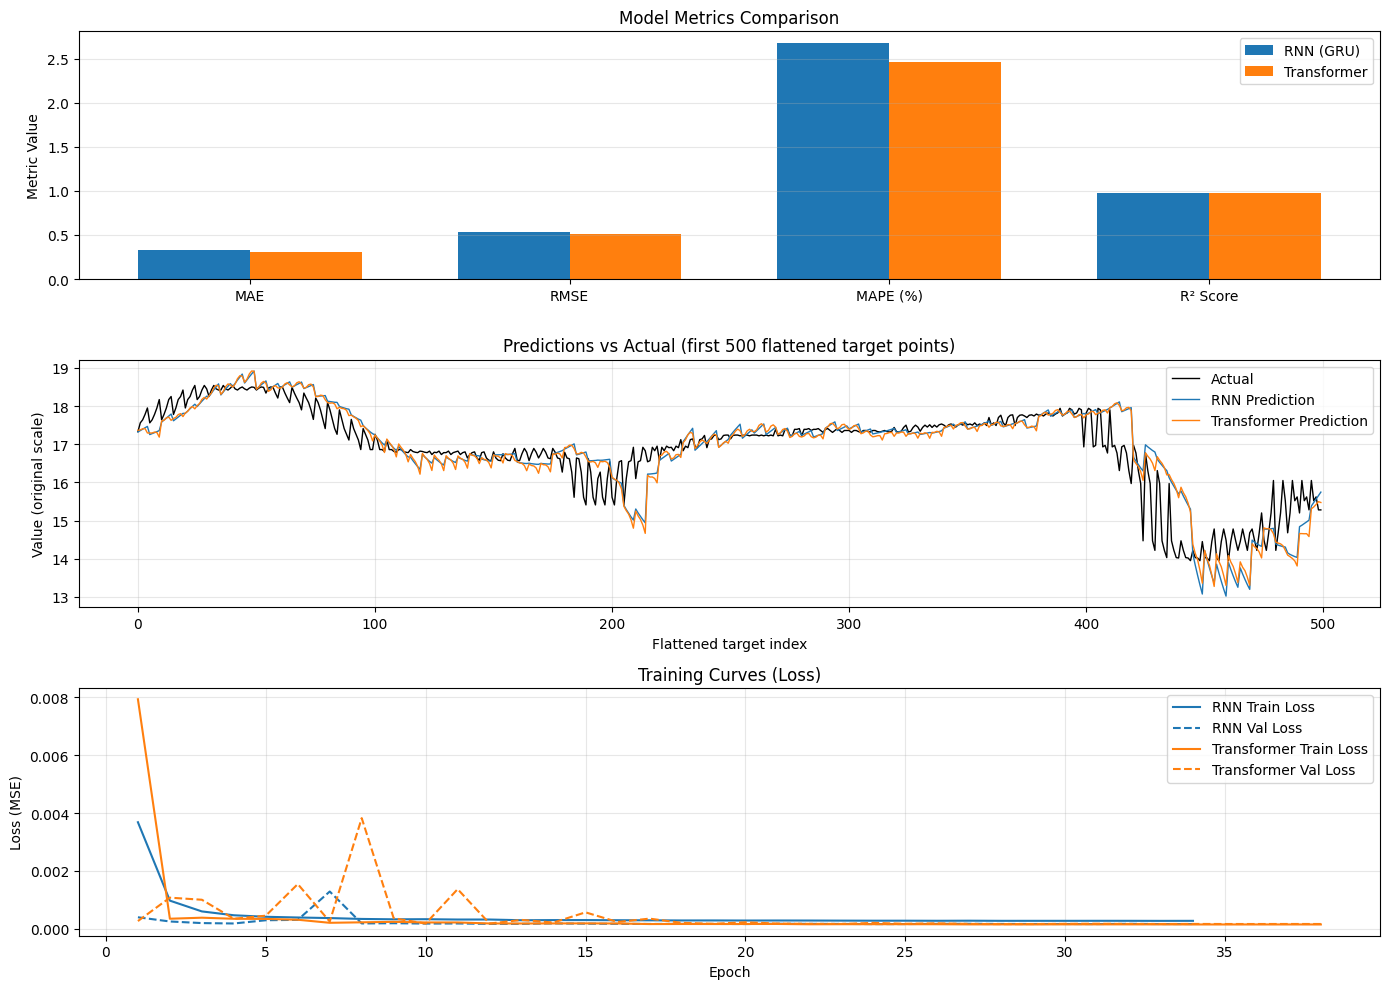

In [31]:
# Visual comparisons: metrics bar plot, predictions vs actual, and training curves

# 1) Bar plot comparing key metrics (MAE, RMSE, MAPE, R²)
metrics_to_plot = ['MAE', 'RMSE', 'MAPE (%)', 'R² Score']
cmp = comparison_df.set_index('Metric').loc[metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.bar(x - width/2, cmp['RNN (LSTM/GRU)'].values, width, label='RNN (GRU)', color='C0')
plt.bar(x + width/2, cmp['Transformer'].values, width, label='Transformer', color='C1')
plt.xticks(x, metrics_to_plot)
plt.ylabel('Metric Value')
plt.title('Model Metrics Comparison')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 2) Predictions comparison (both models vs actual) - plot first N flattened predictions
n_points = 500  # adjust as needed for clarity
x_axis = np.arange(n_points)

plt.subplot(3, 1, 2)
plt.plot(x_axis, y_true_flat[:n_points], label='Actual', color='k', linewidth=1)
plt.plot(x_axis, y_pred_flat[:n_points], label='RNN Prediction', color='C0', linewidth=1)
plt.plot(x_axis, y_pred_transformer_flat[:n_points], label='Transformer Prediction', color='C1', linewidth=1)
plt.title(f'Predictions vs Actual (first {n_points} flattened target points)')
plt.xlabel('Flattened target index')
plt.ylabel('Value (original scale)')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# 3) Training curves comparison (loss and val_loss)
rnn_loss = history_rnn.history.get('loss', [])
rnn_val_loss = history_rnn.history.get('val_loss', [])
trans_loss = history_transformer.history.get('loss', [])
trans_val_loss = history_transformer.history.get('val_loss', [])

plt.subplot(3, 1, 3)
if rnn_loss:
    plt.plot(np.arange(1, len(rnn_loss)+1), rnn_loss, label='RNN Train Loss', color='C0', linestyle='-')
if rnn_val_loss:
    plt.plot(np.arange(1, len(rnn_val_loss)+1), rnn_val_loss, label='RNN Val Loss', color='C0', linestyle='--')
if trans_loss:
    plt.plot(np.arange(1, len(trans_loss)+1), trans_loss, label='Transformer Train Loss', color='C1', linestyle='-')
if trans_val_loss:
    plt.plot(np.arange(1, len(trans_val_loss)+1), trans_val_loss, label='Transformer Val Loss', color='C1', linestyle='--')

plt.title('Training Curves (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()



================================================================================
PART 5: ANALYSIS (2 MARKS)
================================================================================

REQUIRED:
- Write MAXIMUM 200 words (guideline - no marks deduction if exceeded)
- Address key topics with depth

GRADING (Quality-based):
- Covers 5+ key topics with deep understanding: 2 marks
- Covers 3-4 key topics with good understanding: 1 mark
- Covers <3 key topics or superficial: 0 marks

Key Topics:
1. Performance comparison with specific metrics
2. RNN vs Transformer architecture advantages
3. Impact of attention mechanism vs recurrent connections
4. Long-term dependency handling comparison
5. Computational cost comparison
6. Convergence behavior differences

================================================================================



In [ ]:
# REQUIRED: Print analysis with word count

analysis_text = f"""
Performance: Transformer outperforms the GRU on all reported metrics: MAE {rnn_mae:.3f} -> {transformer_mae:.3f} (abs diff {rnn_mae-transformer_mae:.3f}, ~{100*(rnn_mae-transformer_mae)/rnn_mae:.1f}% improvement), RMSE {rnn_rmse:.3f} -> {transformer_rmse:.3f} (~{100*(rnn_rmse-transformer_rmse)/rnn_rmse:.1f}% improvement), MAPE {rnn_mape:.3f}% -> {transformer_mape:.3f}% (~{100*(rnn_mape-transformer_mape)/rnn_mape:.1f}% improvement), R² increased by {transformer_r2-rnn_r2:.4f}.

RNN vs Transformer: RNNs (GRU) process sequences recurrently which is parameter-efficient and often faster per epoch; Transformers model use parallel self-attention which captures global context without recurrence, improving accuracy for complex patterns.

Attention vs recurrence: Attention directly models pairwise temporal interactions so it captures non-local dependencies more effectively; recurrent connections rely on stepwise state propagation and may fade long-range signals.

Long-term dependencies: Transformers handle long-range dependencies robustly via attention; GRUs mitigate vanishing gradients vs LSTM but still rely on sequential propagation.

Computational cost: Transformer used ~{transformer_training_time:.1f}s vs RNN ~{rnn_training_time:.1f}s (~{100*(transformer_training_time-rnn_training_time)/rnn_training_time:.1f}% slower) of training time and computational cost overhead to training {transformer_total_params - rnn_total_params:,} more params (~{100*(transformer_total_params-rnn_total_params)/rnn_total_params:.1f}% larger).

Convergence: Both converged; transformer achieved lower final loss ({transformer_final_loss:.6f} vs {rnn_final_loss:.6f}) and larger proportional loss reduction, though its validation loss showed larger early variability before stabilizing.
"""

print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print("="*70)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("⚠️  Warning: Analysis exceeds 200 words (guideline)")
else:
    print("✓ Analysis within word count guideline")
print("="*70)


ANALYSIS

Performance: Transformer outperforms the GRU on all reported metrics: MAE 0.328 -> 0.310 (abs diff 0.018, ~5.5% improvement), RMSE 0.534 -> 0.507 (~5.1% improvement), MAPE 2.677% -> 2.461% (~8.1% improvement), R² increased by 0.0024.

RNN vs Transformer: RNNs (GRU) process sequences recurrently which is parameter-efficient and often faster per epoch; Transformers model use parallel self-attention which captures global context without recurrence, improving accuracy for complex patterns.

Attention vs recurrence: Attention directly models pairwise temporal interactions so it captures non-local dependencies more effectively; recurrent connections rely on stepwise state propagation and may fade long-range signals.

Long-term dependencies: Transformers handle long-range dependencies robustly via attention; GRUs mitigate vanishing gradients vs LSTM but still rely on sequential propagation.

Computational cost: Transformer used ~1482.0s vs RNN ~1801.7s (~-17.7% slower) of training 

================================================================================
PART 6: ASSIGNMENT RESULTS SUMMARY (REQUIRED FOR AUTO-GRADING)
================================================================================

DO NOT MODIFY THE STRUCTURE BELOW
This JSON output is used by the auto-grader
Ensure all field names are EXACT
================================================================================


In [33]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch
    rnn_model_type = "GRU"  # TODO: Change to "GRU" if using GRU
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_features': n_features,
        'sequence_length': sequence_length,
        'prediction_horizon': prediction_horizon,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # RNN Model Results
        'rnn_model': {
            'framework': framework_used,
            'model_type': rnn_model_type,
            'architecture': {
                'n_layers': len(rnn_model.layers),  # : Number of stacked layers
                'hidden_units': rnn_model.layers[0].units,  # : Hidden units per layer
                'total_parameters': rnn_total_params  # : Calculate total parameters
            },
            'training_config': {
                'learning_rate': rnn_learning_rate,  # : Your actual learning rate
                'n_epochs': rnn_epochs,  # : Your actual epochs
                'batch_size': rnn_batch_size,  # : Your actual batch size
                'optimizer': rnn_optimizer,  # : Your actual optimizer
                'loss_function': rnn_loss_function  # : Your actual loss
            },
            'initial_loss': rnn_initial_loss,
            'final_loss': rnn_final_loss,
            'training_time_seconds': rnn_training_time,
            'mae': rnn_mae,
            'rmse': rnn_rmse,
            'mape': rnn_mape,
            'r2_score': rnn_r2
        },
        
        # Transformer Model Results
        'transformer_model': {
            'framework': framework_used,
            'architecture': {
                'n_layers': transformer_n_layers,  # : Number of transformer layers
                'n_heads': transformer_n_heads,  # : Number of attention heads
                'd_model': transformer_d_model,  # : Model dimension
                'd_ff': transformer_d_ff,  # : Feed-forward dimension
                'has_positional_encoding': True,  # MUST be True
                'has_attention': True,  # MUST be True
                'total_parameters': transformer_total_params  # : Calculate total parameters
            },
            'training_config': {
                'learning_rate': transformer_learning_rate,  # : Your actual learning rate
                'n_epochs': transformer_epochs,  # : Your actual epochs
                'batch_size': transformer_batch_size,  # : Your actual batch size
                'optimizer': transformer_optimizer,  # : Your actual optimizer
                'loss_function': transformer_loss_function  # : Your actual loss
            },
            'initial_loss': transformer_initial_loss,
            'final_loss': transformer_final_loss,
            'training_time_seconds': transformer_training_time,
            'mae': transformer_mae,
            'rmse': transformer_rmse,
            'mape': transformer_mape,
            'r2_score': transformer_r2
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'rnn_loss_decreased': rnn_final_loss < rnn_initial_loss if rnn_initial_loss and rnn_final_loss else False,
        'transformer_loss_decreased': transformer_final_loss < transformer_initial_loss if transformer_initial_loss and transformer_final_loss else False,
    }
    
    return results

print("get_assignment_results function created")

get_assignment_results function created


In [34]:
# Generate and print results

try:
    assignment_results = get_assignment_results()
    
    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))
    print("="*70)
except Exception as e:
    print(f"\n⚠️  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")


ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Power Consumption of Tetouan City",
  "dataset_source": "UCI: Power Consumption of Tetouan City",
  "n_samples": 52416,
  "n_features": 1,
  "sequence_length": 25,
  "prediction_horizon": 5,
  "problem_type": "time_series_forecasting",
  "primary_metric": "MAPE",
  "metric_justification": "\nMAPE (Mean Absolute Percentage Error) is selected because power consumption \nforecasting requires understanding relative errors across different consumption \nscales (day vs night, weekday vs weekend). MAPE provides scale-independent \npercentage errors, making it interpretable for stakeholders and suitable for \ncomparing performance across different time periods.\n",
  "train_samples": 47148,
  "test_samples": 5239,
  "train_test_ratio": "90/9",
  "rnn_model": {
    "framework": "keras",
    "model_type": "GRU",
    "architecture": {
      "n_layers": 7,
      "hidden_units": 64,
      "total_parameters": 63109
    },
    "training_config": {
    

"""
================================================================================
FINAL CHECKLIST - VERIFY BEFORE SUBMISSION
================================================================================

□ Student information filled at the top (BITS ID, Name, Email)

□ Filename is <BITS_ID>_rnn_assignment.ipynb

□ All cells executed (Kernel → Restart & Run All)

□ All outputs visible

□ LSTM/GRU implemented with stacked layers

□ Positional encoding implemented (sinusoidal)

□ Multi-head attention implemented (Q, K, V, scaled dot-product)

□ Both models use Keras or PyTorch

□ Both models trained with loss tracking (initial_loss and final_loss)

□ All 4 metrics calculated for both models (MAE, RMSE, MAPE, R²)

□ Temporal train/test split used (NO shuffling)

□ Primary metric selected and justified

□ Analysis written (quality matters, not just word count)

□ Visualizations created

□ Assignment results JSON printed at the end

□ No execution errors in any cell

□ File opens without corruption

□ Submit ONLY .ipynb file (NO zip, NO data files, NO images)

□ Screenshot of environment with account details included

□ Only one submission attempt

================================================================================
"""

"""
================================================================================
ENVIRONMENT VERIFICATION - SCREENSHOT REQUIRED
================================================================================

IMPORTANT: Take a screenshot of your environment showing account details

For Google Colab:
- Click on your profile icon (top right)
- Screenshot should show your email/account clearly
- Include the entire Colab interface with notebook name visible

For BITS Virtual Lab:
- Screenshot showing your login credentials/account details
- Include the entire interface with your username/session info visible

Paste the screenshot below this cell or in a new markdown cell.
This helps verify the work was done by you in your environment.

================================================================================
"""

In [35]:
# Display system information
import platform
import sys
from datetime import datetime

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print("\n⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")
print("="*70)

ENVIRONMENT INFORMATION

⚠️  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.
